1. DIAGRAMAS DE VORONOI Y TRIANGULACIÓN DE DELAUNAY (copia del ejemplo de moodle)

Para calcular y dibujar el diagrama de Voronoi y la triangulación de Delaunay es necesario importar
de la libería scipy.spatial y de matplotlib las siguientes funciones.

In [9]:
from scipy.spatial import Delaunay,Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib as mpl

Además importaremos la librería numpy para poder generar arrays de puntos.

In [2]:
import numpy as np

El siguiente código genera aleatoriamente 10 puntos en el plano.

In [3]:
points = np.random.rand(10, 2) # 10 random points in 2-D

La siguiente expresión calcula el diagrama de Voronoi.

In [4]:
vor = Voronoi(points)

Para representarlo gráficamente:

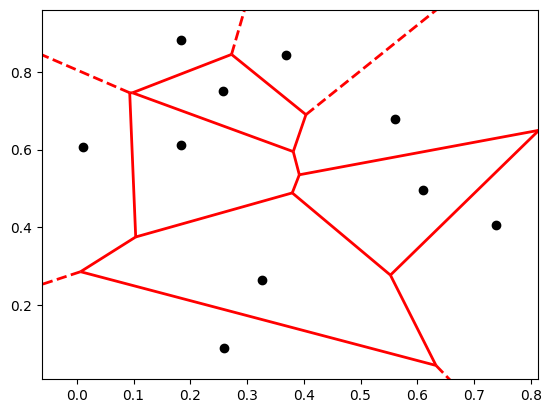

In [5]:
fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='red')
plt.plot(points[:,0], points[:,1], 'ko')

Para calcular la triangulación de Delaunay (se une cada punto con los puntos con regiones de Voronoi adyacentes, es decir, con los que comparte una frontera).

In [6]:
Del=Delaunay(points)

El siguiente comando accede al array de símplices maximales (triángulos) de la triangulación de
Delaunay. ¡Ojo! Los vértices de los símplices no salen ordenados en orden lexicográfico

In [7]:
Del.simplices

array([[0, 4, 3],
       [4, 0, 9],
       [6, 4, 9],
       [6, 2, 4],
       [4, 2, 3],
       [2, 5, 3],
       [8, 2, 6],
       [8, 6, 9],
       [1, 8, 7],
       [8, 1, 2],
       [5, 1, 7],
       [2, 1, 5]], dtype=int32)

Para representar gráficamente la triangulación de Delaunay, imprimiendo los triangulos en color
verde y las aristas y vértices de color negro utilizamos la siguiente línea de comandos.

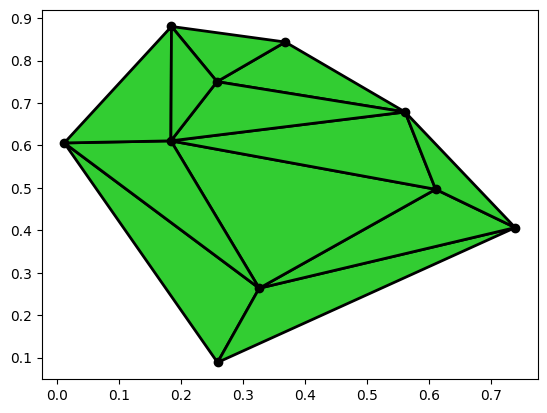

In [8]:
c=np.ones(len(points))
cmap = matplotlib.colors.ListedColormap("limegreen")
plt.tripcolor(points[:,0],points[:,1],Del.simplices, c, edgecolor="k", lw=2,cmap=cmap)
plt.plot(points[:,0], points[:,1], 'ko')
plt.show()

Si queremos representar la triangulación de Delaunay sobre el diagrama de Voronoi hacemos lo
siguiente.

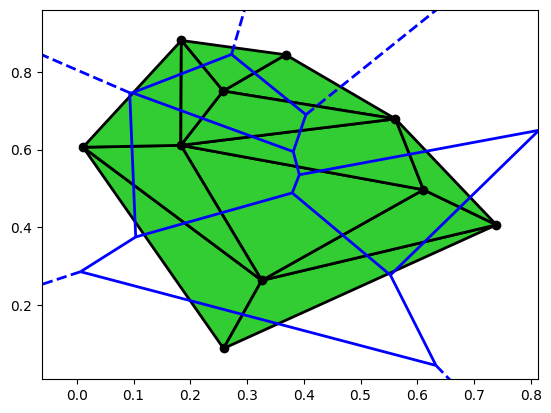

3

In [9]:
fig = voronoi_plot_2d(vor,show_vertices=False,line_width=2, line_colors='blue' )
c=np.ones(len(points))
cmap = matplotlib.colors.ListedColormap("limegreen")
plt.tripcolor(points[:,0],points[:,1],Del.simplices, c, edgecolor="k", lw=2,cmap=cmap)
plt.plot(points[:,0], points[:,1], 'ko')
plt.show()
3


Definir una función que calcule la filtración de alfa complejos asociada a un conjunto de puntos del plano.

Dado un conjunto de puntos S, se define el alfa complejo de radio r de S como el complejo simplicial abstracto formado por todos los símplices para los que todos sus puntos tienen sus Ru(r) (intersecciones de sus regiones de voronoi con la bola de centro u y radio r) con una intersección no vacía.


In [1]:
import numpy as np
from scipy.spatial import Delaunay

class AlfaComplejo:
    """
    Clase para calcular el Alfa Complejo de un conjunto de puntos en 2D.
    
    Atributos:
    - points: np.array de puntos en 2D.
    - triangulation: Triangulación de Delaunay de los puntos.
    - simplices: Lista de símplices (triángulos, aristas y puntos) de la triangulación.
    - alpha_values: Diccionario que almacena los valores de alfa para cada símplice.
    """
    
    def __init__(self, points):
        """
        Inicializa la clase con un conjunto de puntos y calcula la triangulación de Delaunay.
        
        Parámetros:
        - points: np.array de puntos en 2D.
        """
        self.points = points
        self.triangulation = Delaunay(points) # Delaunay solo devuelve los triángulos
        self.simplices = self.get_all_simplices()
        self.alpha_values = self.calculate_alpha_values()

    def get_all_simplices(self):
        """
        Obtiene todos los símplices (puntos, aristas y triángulos) de la triangulación de Delaunay.
        
        Retorna:
        - Lista de símplices.
        """
        simplices = set()
        # Añadir puntos
        for i in range(len(self.points)):
            simplices.add((i,))
        # Añadir aristas y triángulos
        for simplex in self.triangulation.simplices:
            for i in range(3):
                # Añadir aristas
                simplices.add(tuple(sorted([simplex[i], simplex[(i + 1) % 3]])))
            # Añadir triángulos
            simplices.add(tuple(sorted(simplex)))
        return list(simplices)

    def calculate_alpha_values(self):
        """
        Calcula los valores de alfa para cada símplice en la triangulación de Delaunay.
        Seguimos el algoritmo dado en las diapositivas de la asignatura.
        
        Retorna:
        - alpha_values: Diccionario con los valores de alfa para cada símplice.
        """
        alpha_values = {}
        for simplex in self.simplices:
            vertices = self.points[list(simplex)]
            if len(vertices) == 3:
                # Calcular el circunradio para triángulos
                A = np.linalg.norm(vertices[1] - vertices[0])
                B = np.linalg.norm(vertices[2] - vertices[1])
                C = np.linalg.norm(vertices[0] - vertices[2])
                s = (A + B + C) / 2
                area = np.sqrt(s * (s - A) * (s - B) * (s - C))
                circumradius = (A * B * C) / (4 * area)
                alpha_values[tuple(simplex)] = circumradius
            elif len(vertices) == 2:
                # Calcular el radio para aristas
                edge_length = np.linalg.norm(vertices[1] - vertices[0])
                alpha_values[tuple(simplex)] = edge_length / 2
            elif len(vertices) == 1:
                # Los puntos siempre pertenecen al Alfa Complejo
                alpha_values[tuple(simplex)] = 0
        return alpha_values

    def filtrationorder(self):
        """
        Ordena los símplices por el valor de alfa en el que aparecen.
        
        Retorna:
        - Lista de tuplas (símplice, valor de alfa) ordenadas por el valor de alfa.
        """
        return sorted(self.alpha_values.items(), key=lambda item: item[1])

    def thresholdvalues(self):
        """
        Obtiene los valores de umbral de alfa para los que aparecen nuevos símplices.
        
        Retorna:
        - Lista de valores de alfa únicos ordenados.
        """
        return sorted(set(self.alpha_values.values()))
    

    def sublevel(self, threshold):
        """
        Obtiene los símplices cuyo valor de alfa es menor o igual a un umbral dado.
        
        Parámetros:
        - threshold: Umbral de alfa.
        
        Retorna:
        - Lista de símplices cuyo valor de alfa es menor o igual al umbral.
        """
        return [simplex for simplex, alpha in self.alpha_values.items() if alpha <= threshold]



In [2]:
points=np.array([(0.38021546727456423, 0.46419202339598786), (0.7951628297672293, 0.49263630135869474), (0.566623772375203, 0.038325621649018426), (0.3369306814864865, 0.7103735061134965), (0.08272837815822842, 0.2263273314352896), (0.5180166301873989, 0.6271769943824689), (0.33691411899985035, 0.8402045183219995), (0.33244488399729255, 0.4524636520475205), (0.11778991601260325, 0.6657734204021165), (0.9384303415747769, 0.2313873874340855)])

In [3]:
alpha = AlfaComplejo(points)

In [4]:
alpha.filtrationorder()

[((2,), 0),
 ((5,), 0),
 ((8,), 0),
 ((4,), 0),
 ((1,), 0),
 ((7,), 0),
 ((0,), 0),
 ((3,), 0),
 ((9,), 0),
 ((6,), 0),
 ((0, 7), 0.024594630110749274),
 ((3, 6), 0.06491550663246884),
 ((3, 5), 0.09964158316325628),
 ((0, 5), 0.1067160499498478),
 ((3, 8), 0.11181663867459748),
 ((0, 3), 0.12497889333174499),
 ((3, 7), 0.12897443080262758),
 ((0, 3, 7), 0.1292619191823917),
 ((0, 3, 5), 0.129720050879878),
 ((5, 6), 0.13980240119025444),
 ((6, 8), 0.14003715958303004),
 ((3, 6, 8), 0.14290429288721868),
 ((1, 9), 0.14897699064479192),
 ((7, 8), 0.151309131049649),
 ((3, 5, 6), 0.15386007896068227),
 ((1, 5), 0.15403831830169779),
 ((3, 7, 8), 0.1549830251271105),
 ((4, 7), 0.16844581383081997),
 ((0, 1), 0.20796056752930286),
 ((2, 9), 0.20947134070559964),
 ((0, 1, 5), 0.21462894097728322),
 ((4, 8), 0.22042128784724613),
 ((4, 7, 8), 0.2207272203518558),
 ((0, 2), 0.23243829737556373),
 ((2, 7), 0.23788130442736796),
 ((0, 2, 7), 0.24143718415372636),
 ((1, 2), 0.25427755231828075),

In [5]:
alpha.thresholdvalues()

[0,
 0.024594630110749274,
 0.06491550663246884,
 0.09964158316325628,
 0.1067160499498478,
 0.11181663867459748,
 0.12497889333174499,
 0.12897443080262758,
 0.1292619191823917,
 0.129720050879878,
 0.13980240119025444,
 0.14003715958303004,
 0.14290429288721868,
 0.14897699064479192,
 0.151309131049649,
 0.15386007896068227,
 0.15403831830169779,
 0.1549830251271105,
 0.16844581383081997,
 0.20796056752930286,
 0.20947134070559964,
 0.21462894097728322,
 0.22042128784724613,
 0.2207272203518558,
 0.23243829737556373,
 0.23788130442736796,
 0.24143718415372636,
 0.25427755231828075,
 0.25434295608514496,
 0.259566655903143,
 0.2660519202667225,
 0.27011640994552005,
 0.2875741410328021,
 0.7144105889522725]

In [6]:
K=alpha.sublevel(0.26)

Definir una función que represente gráficamente dicho alfa complejo.


In [7]:
# Dada una lista de simplices, plotalpha representa el alfa comlejo sobre el diagraa de Voronoi
def plotalpha(points, K):
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='blue')
    plt.plot(points[:,0], points[:,1], 'ko')
    for simplex in K:
        vertices = points[list(simplex)]
        if len(vertices) == 2:
            plt.plot(vertices[:,0], vertices[:,1], 'k-', lw=2)
        elif len(vertices) == 3:
            plt.fill(vertices[:,0], vertices[:,1], 'g', alpha=0.6)
    plt.show()

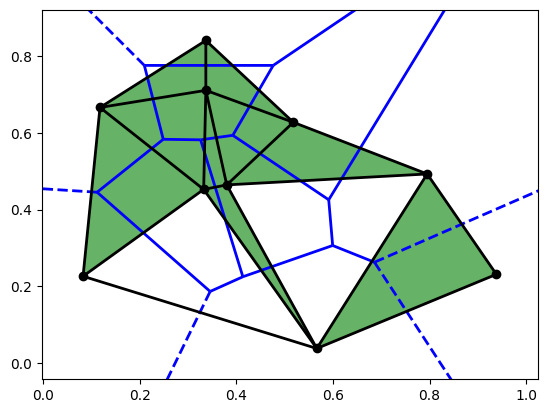

In [10]:
plotalpha(points, K)

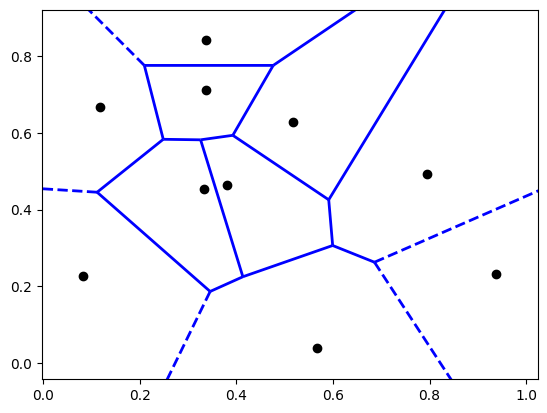

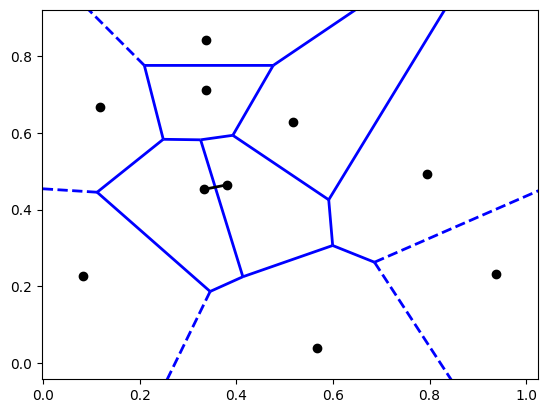

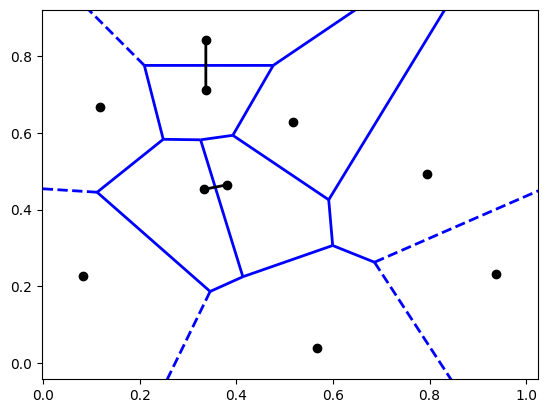

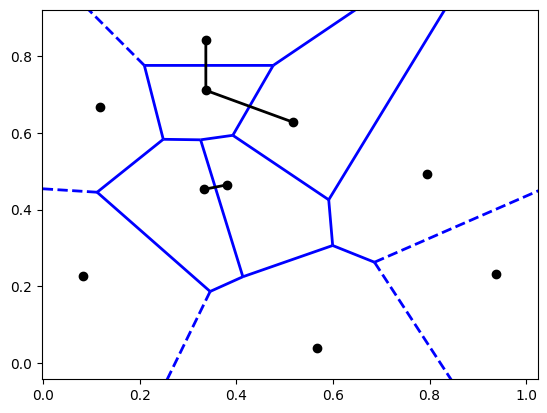

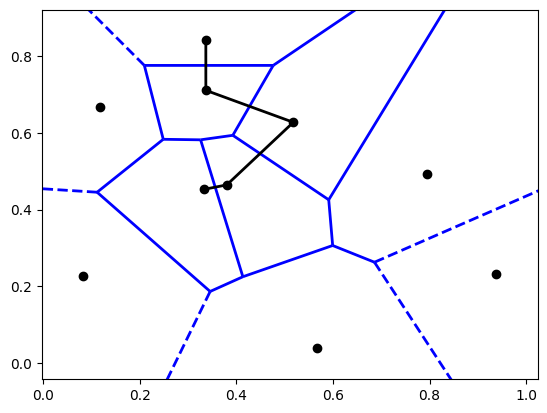

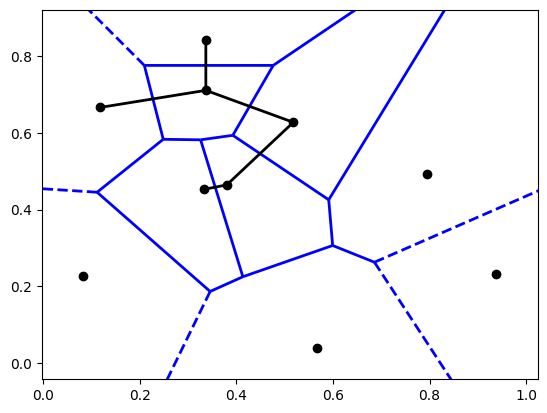

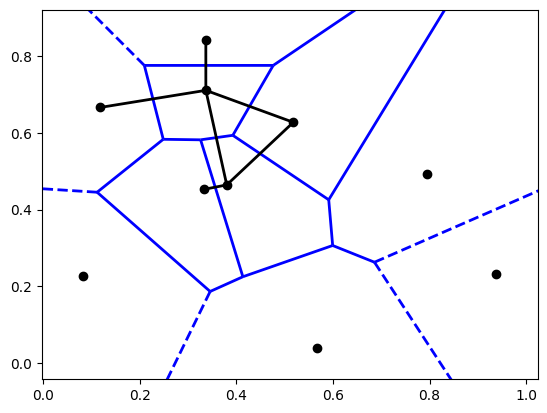

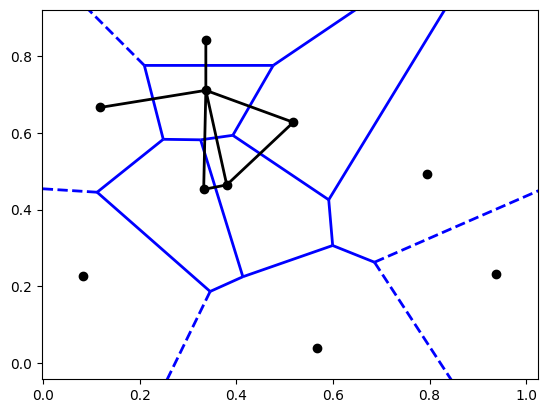

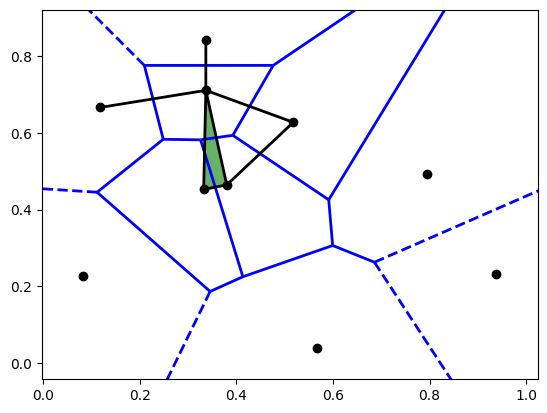

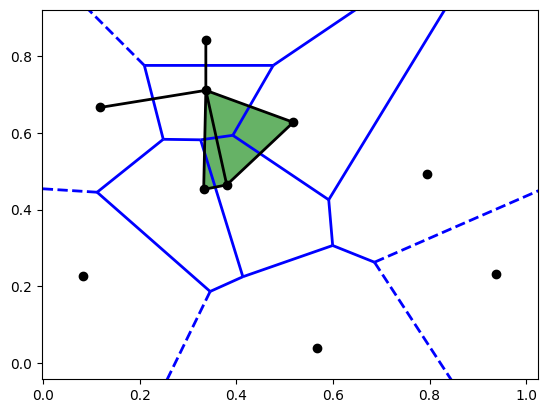

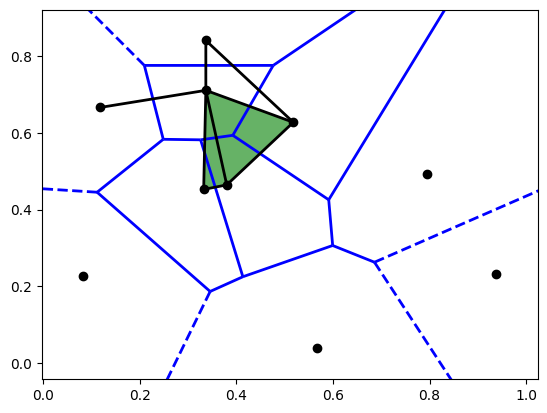

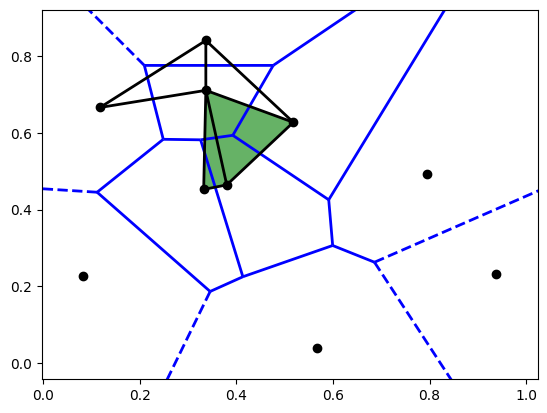

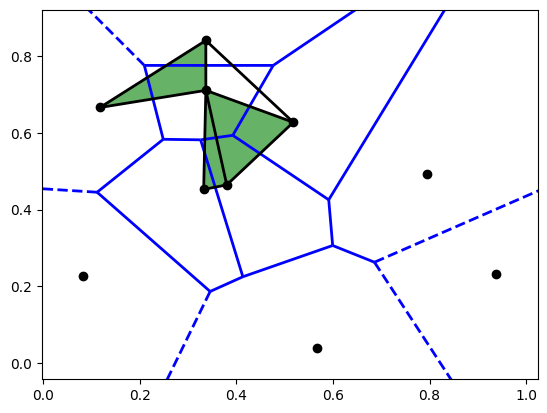

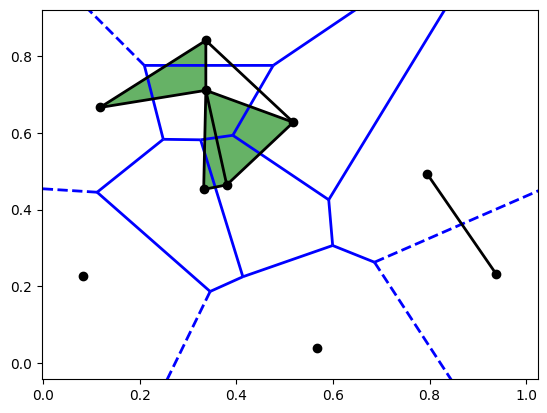

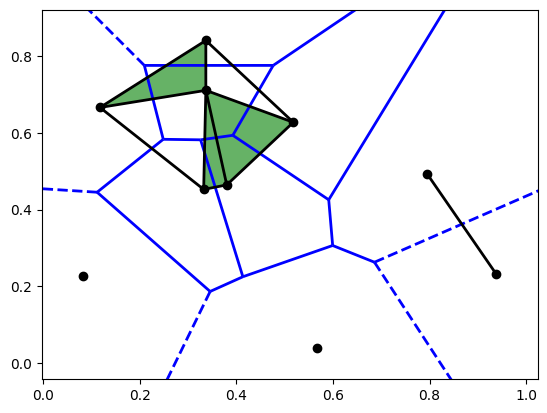

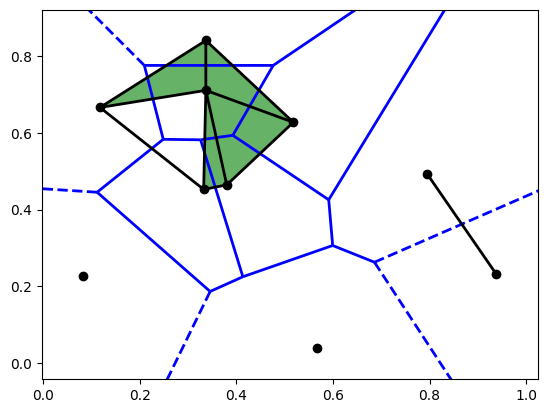

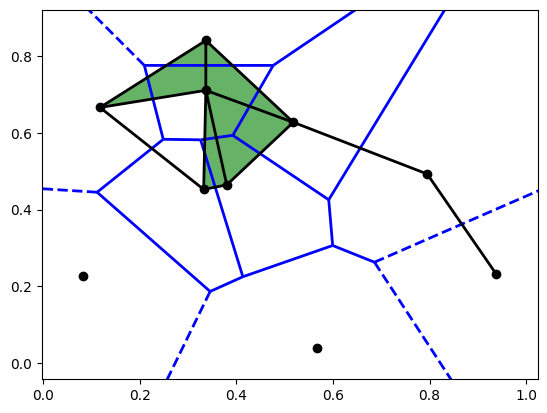

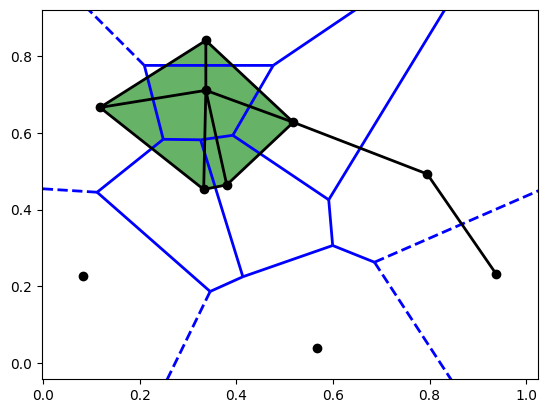

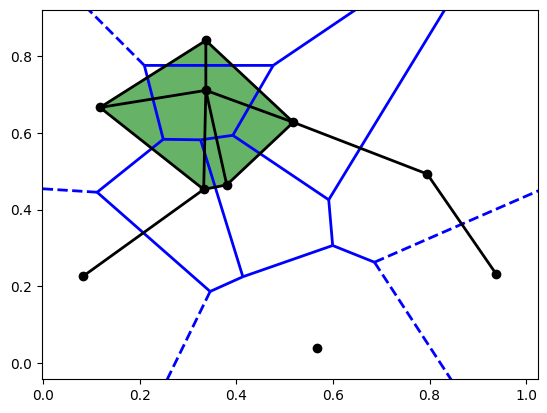

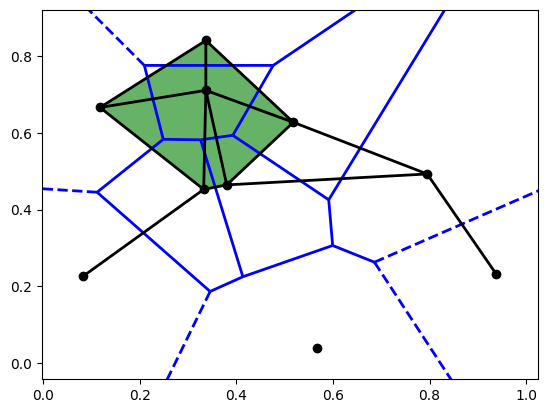

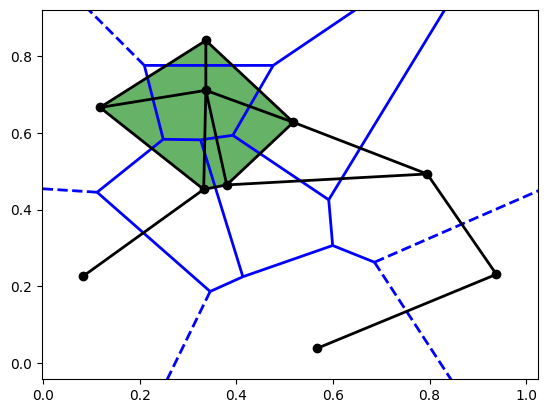

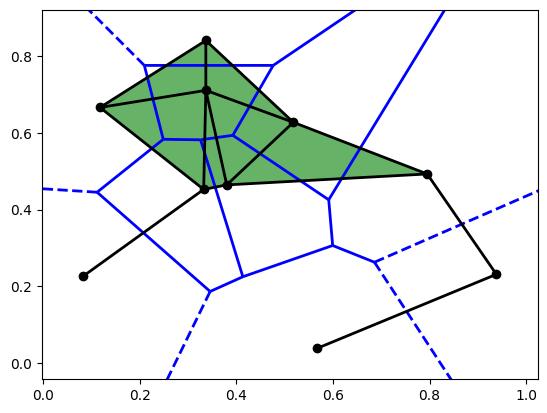

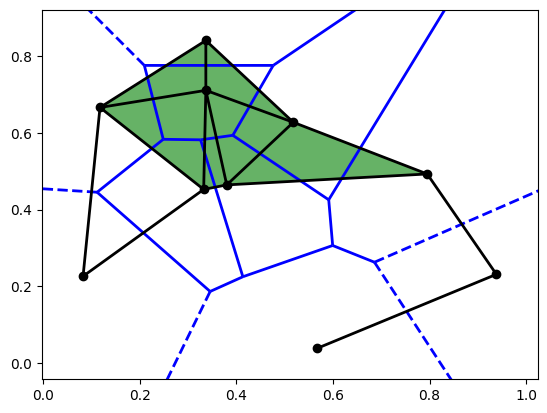

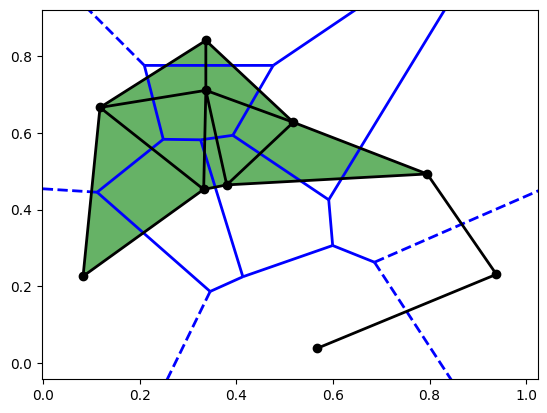

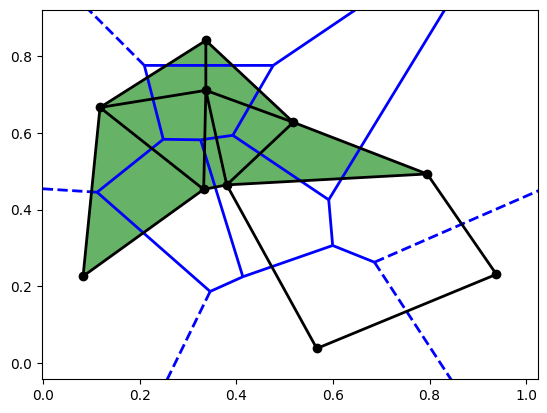

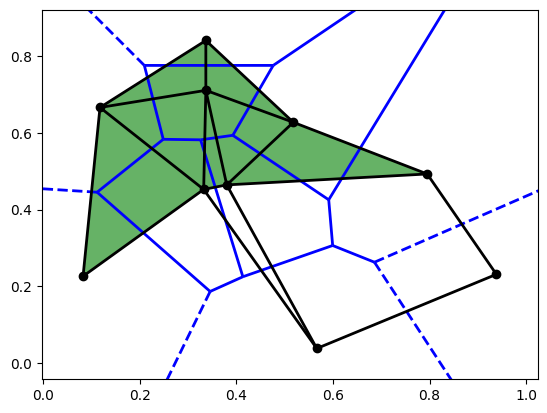

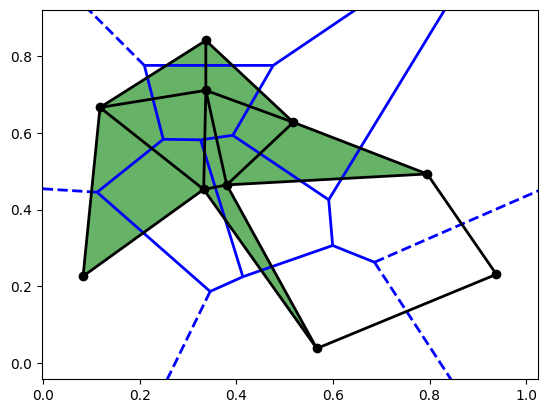

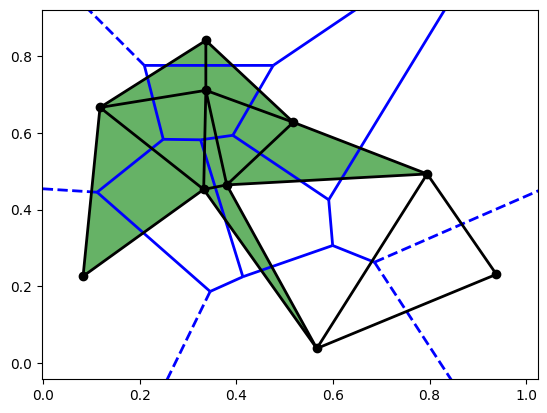

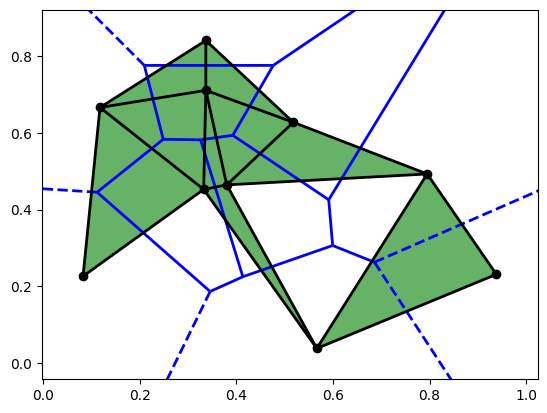

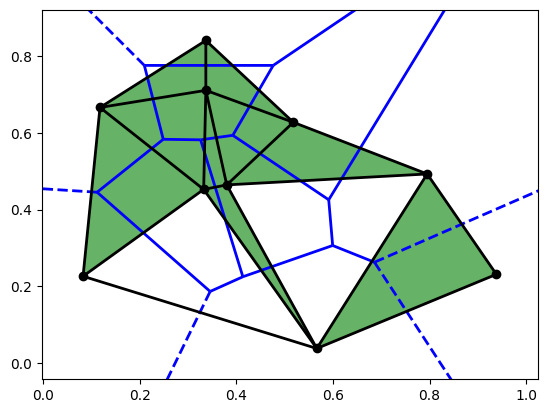

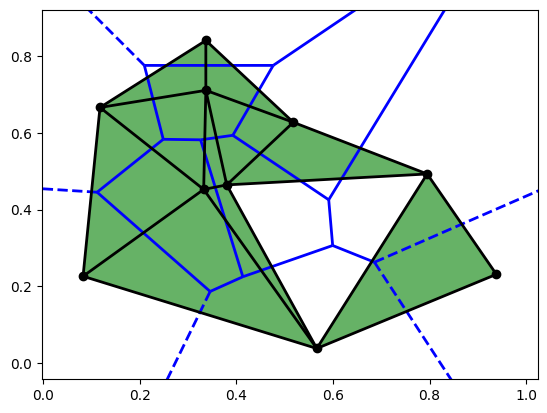

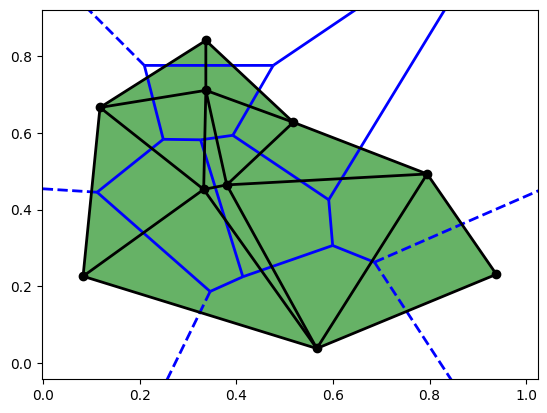

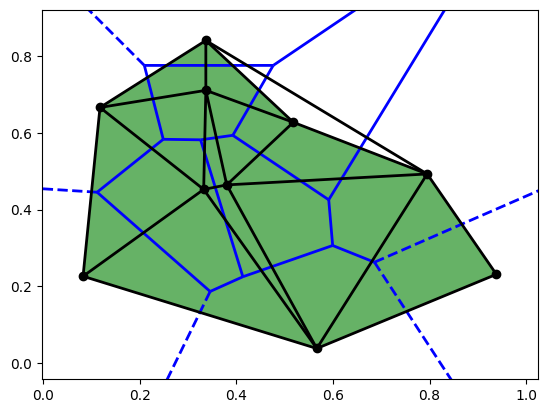

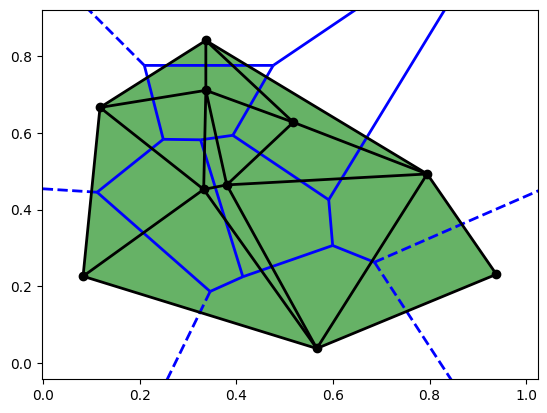

In [11]:
for value in alpha.thresholdvalues():
    K=alpha.sublevel(value)
    plotalpha(points,K)

Definir una función que calcule la filtración de complejos de Vietoris-Rips asociada a un conjunto de puntos.

In [1]:
# Sea S un conjunto de puntos en 2D, el complejo de Vietoris-Rips de S de radio r es el complejo simplicial VR(r)={σ⊂ S ∣ diam σ≤ 2r}

# Esta clase calcula el complejo de Vietoris-Rips de un conjunto de puntos, obteniendo y guardando en un diccionario el valor de r para el que va apareciendo cada símplice.

import numpy as np
from itertools import combinations

class VietorisRipsComplex:
    """
    Clase para calcular el complejo de Vietoris-Rips de un conjunto de puntos en 2D.

    Atributos:
    - points: np.array de puntos en 2D.
    - r_values: Diccionario que almacena el valor de r para cada símplice.
    """

    def __init__(self, points):
        """
        Inicializa la clase con un conjunto de puntos.

        Parámetros:
        - points: np.array de puntos en 2D.
        """
        self.points = points
        self.r_values = self.calculate_r_values()

    def calculate_r_values(self):
        """
        Calcula los valores de r para cada símplice (pares, tríos, etc.) basado en su diámetro.
        
        Retorna:
        - r_values: Diccionario con los valores de r para cada símplice.
        """
        r_values = {}
        num_points = len(self.points)
        
        # Iterar sobre todos los subconjuntos posibles (aristas, triangulos, etc.)
        for k in range(1, num_points + 1):  # Tamaños de símplices
            for simplex in combinations(range(num_points), k):
                vertices = self.points[list(simplex)]
                if len(vertices) > 1:
                    # Calcular el diámetro del simplex
                    diameter = max(np.linalg.norm(a - b) for a, b in combinations(vertices, 2))
                    r_values[simplex] = diameter / 2
                else:
                    # Los puntos individuales siempre pertenecen al complejo
                    r_values[simplex] = 0
        return r_values

    def filtration_order(self):
        """
        Ordena los símplices por el valor de r en el que aparecen.

        Retorna:
        - Lista de tuplas (símplice, valor de r) ordenadas por el valor de r.
        """
        return sorted(self.r_values.items(), key=lambda item: item[1])

    def threshold_values(self):
        """
        Obtiene los valores de umbral de r para los que aparecen nuevos símplices.

        Retorna:
        - Lista de valores de r únicos ordenados.
        """
        return sorted(set(self.r_values.values()))


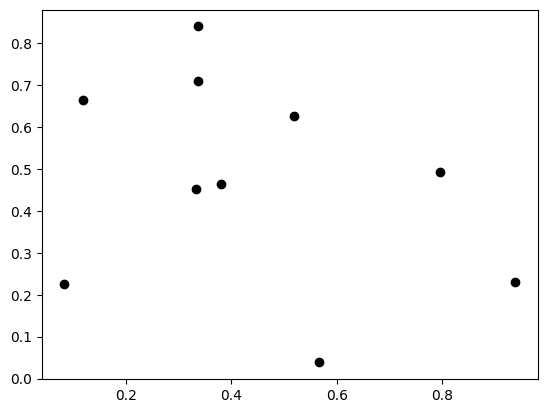

In [4]:
import matplotlib.pyplot as plt

plt.plot(points[:,0],points[:,1],'ko')
plt.show()

In [5]:
VR = VietorisRipsComplex(points)

In [6]:
VR.filtration_order()

[((0,), 0),
 ((1,), 0),
 ((2,), 0),
 ((3,), 0),
 ((4,), 0),
 ((5,), 0),
 ((6,), 0),
 ((7,), 0),
 ((8,), 0),
 ((9,), 0),
 ((0, 7), 0.024594630110749274),
 ((3, 6), 0.06491550663246884),
 ((3, 5), 0.09964158316325628),
 ((0, 5), 0.1067160499498478),
 ((3, 8), 0.11181663867459748),
 ((0, 3), 0.12497889333174499),
 ((0, 3, 5), 0.12497889333174499),
 ((5, 7), 0.12743785247513206),
 ((0, 5, 7), 0.12743785247513206),
 ((3, 7), 0.12897443080262758),
 ((0, 3, 7), 0.12897443080262758),
 ((3, 5, 7), 0.12897443080262758),
 ((0, 3, 5, 7), 0.12897443080262758),
 ((5, 6), 0.13980240119025444),
 ((3, 5, 6), 0.13980240119025444),
 ((6, 8), 0.14003715958303004),
 ((3, 6, 8), 0.14003715958303004),
 ((1, 9), 0.14897699064479192),
 ((7, 8), 0.151309131049649),
 ((3, 7, 8), 0.151309131049649),
 ((1, 5), 0.15403831830169779),
 ((0, 8), 0.16545560550649724),
 ((0, 3, 8), 0.16545560550649724),
 ((0, 7, 8), 0.16545560550649724),
 ((0, 3, 7, 8), 0.16545560550649724),
 ((4, 7), 0.16844581383081997),
 ((0, 6), 0.1

In [7]:
VR.threshold_values()

[0,
 0.024594630110749274,
 0.06491550663246884,
 0.09964158316325628,
 0.1067160499498478,
 0.11181663867459748,
 0.12497889333174499,
 0.12743785247513206,
 0.12897443080262758,
 0.13980240119025444,
 0.14003715958303004,
 0.14897699064479192,
 0.151309131049649,
 0.15403831830169779,
 0.16545560550649724,
 0.16844581383081997,
 0.1892487801168689,
 0.19044564833074332,
 0.19388331119567223,
 0.20104172877828352,
 0.20796056752930286,
 0.20947134070559964,
 0.22042128784724613,
 0.23222927199764715,
 0.23243829737556373,
 0.23788130442736796,
 0.2536662137792591,
 0.25427755231828075,
 0.259566655903143,
 0.2733676600468666,
 0.2875741410328021,
 0.2887027457831261,
 0.2954270609819514,
 0.29587003677268414,
 0.3024077728892547,
 0.32252639022676216,
 0.3322106227332085,
 0.34957492983589655,
 0.35510817894523095,
 0.3802904532397188,
 0.38445726127031843,
 0.3857274202002728,
 0.41706602888011096,
 0.4278584620998067,
 0.4279252460662376,
 0.4642579923126173]